In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hydra
from omegaconf import DictConfig

### データの確認

In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# trainデータの確認
print('データ数：', train.shape[0])
print('カラム：', train.columns)

データ数： 891
カラム： Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [5]:
# 学習データとテストデータの結合
df = pd.concat([train, test], sort=False).reset_index(drop=True)

In [6]:
# 欠損値の確認
print(df.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


### 欠損値の処理

In [7]:
# 'Age'の欠損値を平均値で補完
def fill_null_age(df):
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    return df

df = fill_null_age(df)
print(df.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [8]:
# 'Fare'の欠損値を平均値で補完
def fill_null_fare(df):
    df['Fare'] = df['Fare'].fillna(np.mean(df['Fare']))
    return df

df = fill_null_fare(df)
print(df.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
dtype: int64


In [9]:
# 'Embarked'の欠損値をSで補完
def fill_null_embarked(df):
    df['Embarked'] = df['Embarked'].fillna('S')
    return df

df = fill_null_embarked(df)
print(df.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
dtype: int64


### 外れ値の検出・補正

<AxesSubplot:>

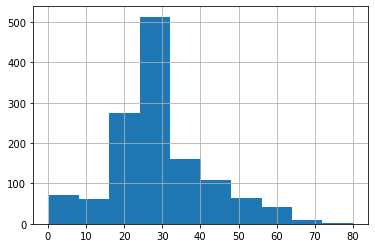

In [10]:
df['Age'].hist()

### 離散化

In [11]:
# 年齢を年代に変換
def binning_age(df):
    df['Age_bin'] = pd.cut(
        df['Age'], 
        bins=[0,10,20,30,40,50,100],
        right=False,
        labels=['U10s', '10s', '20s', '30s', '40s', 'over50s'],
        duplicates='raise',
        include_lowest=True)
    return df

df = binning_age(df)
df[['Age', 'Age_bin']].head()

,Age,Age_bin
0,22.0,20s
1,38.0,30s
2,26.0,20s
3,35.0,30s
4,35.0,30s


### 対数変換

In [12]:
# Fareを対数化
def log_fare(df):
    df['Fare_log'] = np.log1p(df['Fare'])
    return df

df = log_fare(df)
df[['Fare', 'Fare_log']].head()

,Fare,Fare_log
0,7.2500,2.110213
1,71.2833,4.280593
2,7.9250,2.188856
3,53.1000,3.990834
4,8.0500,2.202765


### 名前から敬称を取り出す

In [13]:
honorific_list = []

for name in df['Name']:
    for name_split in name.split():
        if name_split.endswith('.') == True:
            if name_split != 'L.':
                honorific_list.append(name_split)

honorific_unique = set(honorific_list)      

print(list(honorific_unique))

['Mme.', 'Lady.', 'Sir.', 'Col.', 'Dona.', 'Rev.', 'Ms.', 'Mrs.', 'Major.', 'Mlle.', 'Miss.', 'Capt.', 'Master.', 'Don.', 'Dr.', 'Jonkheer.', 'Countess.', 'Mr.']


In [14]:
# 敬称
def honorific_title(df):

    honorific_title_list = ['Dona.', 'Mrs.', 'Dr.', 'Sir.', 'Major.', 'Jonkheer.', 'Col.', 'Countess.', 'Lady.', 'Ms.', 'Mme.', 'Miss.', 'Mlle.', 'Rev.', 'Don.', 'Master.', 'Mr.', 'Capt.']

    for n in honorific_title_list:
        df[f'{n}'] = df['Name'].apply(lambda x: 1 if f'{n}' in x else 0)
    
    return df


df = honorific_title(df)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Lady.,Ms.,Mme.,Miss.,Mlle.,Rev.,Don.,Master.,Mr.,Capt.
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,...,0,0,0,1,0,0,0,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,...,0,0,0,0,0,0,0,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,29.881138,0,0,A.5. 3236,8.0500,...,0,0,0,0,0,0,0,0,1,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,...,0,0,0,0,0,0,0,0,0,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,...,0,0,0,0,0,0,0,0,1,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,29.881138,0,0,359309,8.0500,...,0,0,0,0,0,0,0,0,1,0


### 数値×数値

In [15]:
df['Family'] = df['SibSp'] + df['Parch']
df[['Family', 'SibSp', 'Parch']].head(10)

,Family,SibSp,Parch
0,1,1,0
1,1,1,0
2,0,0,0
3,1,1,0
4,0,0,0
5,0,0,0
6,0,0,0
7,4,3,1
8,2,0,2
9,1,1,0


### 数値×カテゴリ変数

In [16]:
df['mean_Fare_by_Sex'] = df.groupby('Sex')['Fare'].transform('mean')
df[['Sex', 'Fare', 'mean_Fare_by_Sex']]

,Sex,Fare,mean_Fare_by_Sex
0,male,7.2500,26.163072
1,female,71.2833,46.198097
2,female,7.9250,46.198097
3,female,53.1000,46.198097
4,male,8.0500,26.163072
...,...,...,...
1304,male,8.0500,26.163072
1305,female,108.9000,46.198097
1306,male,7.2500,26.163072
1307,male,8.0500,26.163072


### カテゴリ変数 × カテゴリ変数 ： 出現回数

In [17]:
# 'Sex' × 'Embarked'：出現回数
def count_sex_x_embarked(df):
    df['count_Sex_x_Embarked'] = df.groupby(['Sex', 'Embarked'])['PassengerId'].transform('count')
    return df

df = count_sex_x_embarked(df)
df[['Sex', 'Embarked', 'count_Sex_x_Embarked']].head()

,Sex,Embarked,count_Sex_x_Embarked
0,male,S,623
1,female,C,113
2,female,S,293
3,female,S,293
4,male,S,623


### カテゴリ変数　×　カテゴリ変数　：　出現割合

In [18]:
# 'Sex' × 'Cabin'：出現割合
def rate_sex_x_cabin(df):
    df_tbl = pd.crosstab(df['Sex'], df['Cabin'], normalize='index')
    print('集約テーブル（行方向の和で割る）')
    display(df_tbl)
    df_tbl = df_tbl.reset_index()
    df_tbl = pd.melt(df_tbl, id_vars='Sex', value_name='rate_Sex_x_Cabin')
    print('集約テーブル（縦持ち変換後）')
    display(df_tbl)
    df = pd.merge(df, df_tbl, on=['Sex', 'Cabin'], how='left')
    return df

df = rate_sex_x_cabin(df)
df[['Sex', 'Cabin', 'rate_Sex_x_Cabin']].head()

集約テーブル（行方向の和で割る）


Cabin,A10,A11,A14,A16,A18,A19,A20,A21,A23,A24,...,F E57,F E69,F G63,F G73,F2,F33,F38,F4,G6,T
Sex,,,,,,,,,,,,,,,,,,,,,
female,0.000000,0.007092,0.000000,0.007092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.007092,0.000000,0.000000,0.000000,0.028369,0.000000,0.021277,0.035461,0.000000
male,0.006494,0.000000,0.006494,0.000000,0.006494,0.006494,0.006494,0.006494,0.006494,0.006494,...,0.006494,0.000000,0.012987,0.012987,0.025974,0.000000,0.006494,0.006494,0.000000,0.006494


集約テーブル（縦持ち変換後）


,Sex,Cabin,rate_Sex_x_Cabin
0,female,A10,0.000000
1,male,A10,0.006494
2,female,A11,0.007092
3,male,A11,0.000000
4,female,A14,0.000000
...,...,...,...
367,male,F4,0.006494
368,female,G6,0.035461
369,male,G6,0.000000
370,female,T,0.000000


,Sex,Cabin,rate_Sex_x_Cabin
0,male,NaN,NaN
1,female,C85,0.007092
2,female,NaN,NaN
3,female,C123,0.007092
4,male,NaN,NaN


In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Mlle.,Rev.,Don.,Master.,Mr.,Capt.,Family,mean_Fare_by_Sex,count_Sex_x_Embarked,rate_Sex_x_Cabin
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,1,0,1,26.163072,623,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,1,46.198097,113,0.007092
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,46.198097,293,NaN
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,1,46.198097,293,0.007092
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,1,0,0,26.163072,623,NaN


### Cabin

In [20]:
# Cabinの先頭を取り出す
def initial_cabin(df):
    df['Cabin'] = df['Cabin'].fillna('Unknown')
    df['Cabin_label']=df['Cabin'].str.get(0)
    return df

df = initial_cabin(df)
df[['Cabin', 'Cabin_label']]

,Cabin,Cabin_label
0,Unknown,U
1,C85,C
2,Unknown,U
3,C123,C
4,Unknown,U
...,...,...
1304,Unknown,U
1305,C105,C
1306,Unknown,U
1307,Unknown,U


### One-Hot Encoding


In [21]:
# One-Hot Encoding
def ohe(df):
    df_ohe = pd.get_dummies(df[['Sex', 'Embarked']], drop_first=False)
    df = pd.concat([df, df_ohe], axis=1)
    return df

df = ohe(df)

In [22]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_bin', 'Fare_log',
       'Dona.', 'Mrs.', 'Dr.', 'Sir.', 'Major.', 'Jonkheer.', 'Col.',
       'Countess.', 'Lady.', 'Ms.', 'Mme.', 'Miss.', 'Mlle.', 'Rev.', 'Don.',
       'Master.', 'Mr.', 'Capt.', 'Family', 'mean_Fare_by_Sex',
       'count_Sex_x_Embarked', 'rate_Sex_x_Cabin', 'Cabin_label', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [23]:
df[['Sex', 'Sex_female', 'Sex_male']].head(10)

,Sex,Sex_female,Sex_male
0,male,0,1
1,female,1,0
2,female,1,0
3,female,1,0
4,male,0,1
5,male,0,1
6,male,0,1
7,male,0,1
8,female,1,0
9,female,1,0


In [24]:
df[['Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].head(10)

,Embarked,Embarked_C,Embarked_Q,Embarked_S
0,S,0,0,1
1,C,1,0,0
2,S,0,0,1
3,S,0,0,1
4,S,0,0,1
5,Q,0,1,0
6,S,0,0,1
7,S,0,0,1
8,S,0,0,1
9,C,1,0,0


In [25]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_bin', 'Fare_log',
       'Dona.', 'Mrs.', 'Dr.', 'Sir.', 'Major.', 'Jonkheer.', 'Col.',
       'Countess.', 'Lady.', 'Ms.', 'Mme.', 'Miss.', 'Mlle.', 'Rev.', 'Don.',
       'Master.', 'Mr.', 'Capt.', 'Family', 'mean_Fare_by_Sex',
       'count_Sex_x_Embarked', 'rate_Sex_x_Cabin', 'Cabin_label', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')